In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from missingno import matrix as ms_matrix, heatmap as ms_heatmap
import seaborn as sns
import math
from scipy import stats
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OrdinalEncoder , StandardScaler , RobustScaler , MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import TomekLinks,EditedNearestNeighbours
from imblearn.combine import SMOTETomek
from sklearn.decomposition import PCA as SKPCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import joblib

class MachineLearning:
    def __init__(self,
                 df=None,
                 target=None,
                 X=None,
                 y=None,
                 train=None,
                 test=None,
                 classification = False,
                 regression=True
                 ):
        self.df = df
        self.target = target
        self.X = X
        self.y = y
        self.train = train
        self.test = test
        self.scaler=None
        self.encoder=None
        self.new={}
        self.classification = classification
        self.regression = regression
        if self.classification == True or self.regression  == False:
            self.classification == True
        elif self.classification == False or self.regression  == True:
            self.regression == True      
    #----------- print Block--------
    def print_block(self,
                    title,
                    width=43,
                    center=True
                    ):
        print("-" * width)
        if center:
            print(title.center(width))
        else:
            print(title)
        print("-" * width)
    # ---------- display ----------
    def display_data(
        self,
        head_rows=5,
        describe=True,
        info=True,
        shape=True,
        columns=True,
        unique=False,
        unique_values_size=10,
        most_frequent=True
    ):
        data_dict = {}

        if self.df is not None:
            data_dict["DataFrame"] = self.df

        if self.X is not None and self.y is not None:
            X_df = pd.DataFrame(self.X)
            y_df = pd.Series(self.y, name="y")
            data_dict["X / y"] = pd.concat([X_df, y_df], axis=1)

        if self.train is not None and self.test is not None:
            train_df = self.train if isinstance(self.train, pd.DataFrame) else pd.DataFrame(self.train[0])
            test_df = self.test if isinstance(self.test, pd.DataFrame) else pd.DataFrame(self.test[0])
            data_dict["Train"] = train_df
            data_dict["Test"] = test_df

        if not data_dict:
            print("No data available.")
            return

        for name, df in data_dict.items():
            self.print_block(name)
            print(f"Target: {self.target}\n")

            # Head
            self.print_block("HEAD")
            print(df.head(head_rows), "\n")

            # Info
            if info:
                self.print_block("INFO")
                df.info()
                print()

            # Describe
            if describe:
                self.print_block("SUMMARY (Mean / Median / Std)")
                numeric_cols = df.select_dtypes(include=np.number).columns
                if len(numeric_cols) > 0:
                    summary = pd.DataFrame({
                        "Mean": df[numeric_cols].mean(),
                        "Median": df[numeric_cols].median(),
                        "Std": df[numeric_cols].std()
                    })
                    print(summary, "\n")
                else:
                    print("No numeric columns.\n")

            # Shape
            if shape:
                self.print_block("SHAPE")
                print(df.shape, "\n")

            # Columns
            if columns:
                self.print_block("COLUMNS")
                print(df.columns.tolist(), "\n")

            # Unique
            if unique:
                self.print_block("UNIQUE VALUES")
                for col in df.columns:
                    n = df[col].nunique()
                    if n <= unique_values_size:
                        print(f"{col}: {n} -> {df[col].unique()}")
                    else:
                        print(f"{col}: {n}")
                print()
            # Most Frequent
            if most_frequent:
                self.print_block("MOST FREQUENT VALUES")
                for col in df.columns:
                    most_freq = df[col].value_counts().idxmax()
                    freq_count = df[col].value_counts().max()
                    print(f"{col}: {most_freq} ({freq_count} times)")
                print()
    # ---------- null values ----------
    def null_values_shows(self,
                    figsize=(10, 6),
                    fontsize=12,
                    show_heatmap=False,
                    show_matrix=False ,
                    ascending=False
                    ):
        data_dict = {}

        if self.df is not None:
            data_dict["DataFrame"] = self.df

        if self.X is not None and self.y is not None:
            X_df = pd.DataFrame(self.X)
            y_df = pd.Series(self.y, name="y")
            data_dict["X / y"] = pd.concat([X_df, y_df], axis=1)

        if self.train is not None and self.test is not None:
            train_df = self.train if isinstance(self.train, pd.DataFrame) else pd.DataFrame(self.train[0])
            test_df = self.test if isinstance(self.test, pd.DataFrame) else pd.DataFrame(self.test[0])
            data_dict["Train"] = train_df
            data_dict["Test"] = test_df

        for name, df in data_dict.items():
            nulls = df.isnull().sum()
            total_rows = len(df)

            if nulls.sum() == 0:
                print("No missing values \n")
            else:
                null_df = pd.DataFrame({
                    "Missing Count": nulls,
                    "Missing %": (nulls / total_rows * 100).round(2)
                })

                null_df = null_df[null_df["Missing Count"] > 0]

                self.print_block("MISSING VALUES SUMMARY")
                if ascending:
                    null_df = null_df.sort_values(by="Missing Count", ascending=True)
                else:
                    null_df = null_df.sort_values(by="Missing Count", ascending=False)
                print(null_df, "\n")

            if show_heatmap:
                plt.figure(figsize=figsize)
                ms_heatmap(df)
                plt.title(f"Null Heatmap - {name}", fontsize=fontsize)
                plt.show()

            if show_matrix:
                ms_matrix(df, figsize=figsize, fontsize=fontsize)
                plt.title(f"Missing Matrix - {name}", fontsize=fontsize)
                plt.show()
    # ---------- outliers detection ----------
    def outliers_detection(self , ascending=False , box_plot=False):
        data_dict = {}

        if self.df is not None:
            data_dict["DataFrame"] = self.df

        if self.X is not None and self.y is not None:
            X_df = pd.DataFrame(self.X)
            y_df = pd.Series(self.y, name="y")
            data_dict["X / y"] = pd.concat([X_df, y_df], axis=1)

        if self.train is not None and self.test is not None:
            train_df = self.train if isinstance(self.train, pd.DataFrame) else pd.DataFrame(self.train[0])
            test_df = self.test if isinstance(self.test, pd.DataFrame) else pd.DataFrame(self.test[0])
            data_dict["Train"] = train_df
            data_dict["Test"] = test_df

        for name, df in data_dict.items():
            numeric_cols = df.select_dtypes(include=np.number).columns
            if len(numeric_cols) == 0:
                print(f"No numeric columns in {name} for outlier detection.\n")
                continue

            outlier_summary = {}
            for col in numeric_cols:
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
                outlier_summary[col] = len(outliers)

            self.print_block(f"OUTLIER DETECTION - {name}")
            if ascending:
                outlier_summary = dict(sorted(outlier_summary.items(), key=lambda item: item[1], reverse=False))
            else:
                outlier_summary = dict(sorted(outlier_summary.items(), key=lambda item: item[1], reverse=True))
                
            for col, count in outlier_summary.items():
                print(f"{col}: {outlier_summary[col]} outliers")
            print()
            if box_plot:
                n = len(df.columns)
                n_cols = 3
                n_rows = math.ceil(n / n_cols)

                plt.figure(figsize=(n_cols * 4, n_rows * 3))
                for i, col in enumerate(df.columns, 1):
                    plt.subplot(n_rows, n_cols, i)

                    if df[col].dtype in ['int64', 'float64']:
                        plt.boxplot(df[col])
                    else:
                        plt.bar(df[col].value_counts().index, df[col].value_counts().values)

                    plt.title(col)
                plt.tight_layout()
                plt.show()
    # ---------- visualize data ----------
    def visualize_data(self,
                       target_col=None,
                       scatter_with_target=False ,
                       histogram=False , correlation_heatmap=False  ,
                       box_plot=False  ,
                       scatter_matrix=False  ,
                       pair_plot=False ,
                       figsize=(10,6) ,
                       fontsize=12,
                       bins=30,
                       correlation_method='pearson'
                       ):
        data_dict = {}

        if self.df is not None:
            data_dict["DataFrame"] = self.df

        if self.X is not None and self.y is not None:
            X_df = pd.DataFrame(self.X)
            y_df = pd.Series(self.y, name="y")
            data_dict["X / y"] = pd.concat([X_df, y_df], axis=1)

        if self.train is not None and self.test is not None:
            train_df = self.train if isinstance(self.train, pd.DataFrame) else pd.DataFrame(self.train[0])
            test_df = self.test if isinstance(self.test, pd.DataFrame) else pd.DataFrame(self.test[0])
            data_dict["Train"] = train_df
            data_dict["Test"] = test_df
        for name, df in data_dict.items():
            self.print_block(f"VISUALIZING DATA - {name}")
            if histogram:
                df.hist(bins=bins, figsize=figsize)
                plt.suptitle(f"Histograms - {name}", fontsize=fontsize)
                plt.show()

            if correlation_heatmap:
                plt.figure(figsize=figsize)
                corr = df.corr(method=correlation_method)
                sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
                plt.title(f"Correlation Heatmap ({correlation_method}) - {name}", fontsize=fontsize)
                plt.show()

            if box_plot:
                numeric_cols = df.select_dtypes(include=np.number).columns
                if len(numeric_cols) > 0:
                    n = len(numeric_cols)
                    n_cols = 3
                    n_rows = math.ceil(n / n_cols)

                    plt.figure(figsize=(n_cols * 4, n_rows * 3))
                    for i, col in enumerate(numeric_cols, 1):
                        plt.subplot(n_rows, n_cols, i)
                        plt.boxplot(df[col])
                        plt.title(col)
                    plt.suptitle(f"Box Plots - {name}", fontsize=fontsize)
                    plt.tight_layout()
                    plt.show()
                else:
                    print(f"No numeric columns for box plots in {name}.\n")

            if scatter_matrix:
                print("warning: scatter matrix may take a while for large datasets.")
                print("press y/n to continue or skip:")
                user_input = input().lower()
                if user_input == 'y':
                    pd.plotting.scatter_matrix(df, figsize=figsize)
                    plt.suptitle(f"Scatter Matrix - {name}", fontsize=fontsize)
                    plt.show()
                else:
                    print("Skipping scatter matrix visualization.")
                    
            if scatter_with_target:
                if target_col is None:
                    target_col = self.target
                if target_col is None or target_col not in df.columns:
                    print(f"Target column '{target_col}' is not specified or not found in {name}.\n")
                    continue
                numeric_cols = df.select_dtypes(include=np.number).columns
                if target_col not in numeric_cols:
                    print(f"Target column '{target_col}' is not numeric in {name}.\n")
                    continue

                n = len(numeric_cols) - 1  # Exclude target column
                n_cols = 3
                n_rows = math.ceil(n / n_cols)

                plt.figure(figsize=(n_cols * 4, n_rows * 3))
                plot_index = 1
                for col in numeric_cols:
                    if col == target_col:
                        continue
                    plt.subplot(n_rows, n_cols, plot_index)
                    plt.scatter(df[col], df[target_col], alpha=0.5)
                    plt.xlabel(col)
                    plt.ylabel(target_col)
                    plt.title(f"{col} vs {target_col}")
                    plot_index += 1
                plt.tight_layout()
                plt.show()
                

            if pair_plot:
                sns.pairplot(df)
                plt.suptitle(f"Pair Plot - {name}", fontsize=fontsize)
                plt.show()
    # ---------- handle missing values ----------
    def handle_missing_values(self ,
                              drop_threshold=0.5,
                              impute_strategy='mean',
                              dtype_specific="auto"
                              ):
        data_dict = {}

        if self.df is not None:
            data_dict["DataFrame"] = self.df

        if self.X is not None and self.y is not None:
            X_df = pd.DataFrame(self.X)
            y_df = pd.Series(self.y, name="y")
            data_dict["X / y"] = pd.concat([X_df, y_df], axis=1)

        if self.train is not None and self.test is not None:
            train_df = self.train if isinstance(self.train, pd.DataFrame) else pd.DataFrame(self.train[0])
            test_df = self.test if isinstance(self.test, pd.DataFrame) else pd.DataFrame(self.test[0])
            data_dict["Train"] = train_df
            data_dict["Test"] = test_df
            

        for name, df in data_dict.items():
            self.print_block(f"HANDLE MISSING VALUES - {name}")
            # Drop columns with missing value percentage above threshold
            numeric_cols = df.select_dtypes(include=np.number).columns
            categorical_cols = df.select_dtypes(include=['object', 'category']).columns
            if df.isna().sum().sum() == 0:
                print(f"No missing values to handle in {name}.\n")
                continue
            missing_percent = df.isnull().mean()
            cols_to_drop = missing_percent[missing_percent > drop_threshold].index
            df.drop(columns=cols_to_drop, inplace=True)
            
            # Impute missing values
            for col in df.columns:
                if df[col].isnull().sum() > 0 and col not in cols_to_drop:
                    if dtype_specific == "auto":
                        if col in numeric_cols and impute_strategy =="mean":
                            df[col].fillna(df[col].mean(), inplace=True)
                        elif col  in numeric_cols and impute_strategy =="median":
                            df[col].fillna(df[col].median(), inplace=True)
                        elif col in categorical_cols and impute_strategy =="mode":
                            df[col].fillna(df[col].mode()[0], inplace=True)
                            
                    elif dtype_specific == "numeric":
                        if col in numeric_cols:
                            if impute_strategy == "mean":
                                df[col].fillna(df[col].mean(), inplace=True)
                            elif impute_strategy == "median":
                                df[col].fillna(df[col].median(), inplace=True)
                                
                    elif dtype_specific == "categorical":
                        if col in categorical_cols:
                            if impute_strategy == "mode":
                                df[col].fillna(df[col].mode()[0], inplace=True)
    # ---------- remove outliers ----------
    def remove_outliers(self, technique='iqr', before_after=True, box_plot=True , apply=False , keep_cols=[]):
        print("make apply = True if NEEDS OUTLIER REMOVAL?:")
        
        if not apply:
            self.print_block("OUTLIER REMOVAL CANCELED")
            return
        
        data_dict = {}

        if self.df is not None:
            data_dict["DataFrame"] = self.df

        if self.X is not None and self.y is not None:
            X_df = pd.DataFrame(self.X)
            y_df = pd.Series(self.y, name="y")
            data_dict["X / y"] = pd.concat([X_df, y_df], axis=1)

        if self.train is not None and self.test is not None:
            train_df = self.train if isinstance(self.train, pd.DataFrame) else pd.DataFrame(self.train[0])
            test_df = self.test if isinstance(self.test, pd.DataFrame) else pd.DataFrame(self.test[0])
            data_dict["Train"] = train_df
            data_dict["Test"] = test_df
            
        def count_outliers(df, col):
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            return df[(df[col] < lower) | (df[col] > upper)].shape[0]

        def plot_box(df, title):
            numeric_cols = df.select_dtypes(include=np.number).columns
            n = len(numeric_cols)
            n_cols = 3
            n_rows = math.ceil(n / n_cols)
            plt.figure(figsize=(n_cols * 4, n_rows * 3))
            for i, col in enumerate(numeric_cols, 1):
                plt.subplot(n_rows, n_cols, i)
                plt.boxplot(df[col])
                plt.title(col)
            plt.title(title, fontsize=12)
            plt.tight_layout()
            plt.show()
        
        for name, df in data_dict.items():
            self.print_block(f"REMOVE OUTLIERS - {name}")
            numeric_cols = df.select_dtypes(include=np.number).columns
            if len(numeric_cols) == 0:
                print(f"No numeric columns in {name} for outlier removal.\n")
                continue

            # Filter out columns to keep (don't process them)
            cols_to_process = [col for col in numeric_cols if col not in keep_cols]
            
            if before_after:
                print(f"Before outlier removal - {name}")
                for col in cols_to_process:
                    print(f"{col}: {count_outliers(df, col)} outliers")
                print()
            if box_plot:
                plot_box(df, f"Box Plots Before Outlier Removal - {name}")
            
            # --- Apply technique ---
            for col in cols_to_process:
                if technique == 'iqr':
                    Q1 = df[col].quantile(0.25)
                    Q3 = df[col].quantile(0.75)
                    IQR = Q3 - Q1
                    lower = Q1 - 1.5 * IQR
                    upper = Q3 + 1.5 * IQR
                    df[col] = np.clip(df[col], lower, upper)
                elif technique == 'z_score':
                    mean = df[col].mean()
                    std = df[col].std()
                    z_scores = (df[col] - mean) / std
                    df[col] = np.where(z_scores < -3, mean - 3*std, np.where(z_scores > 3, mean + 3*std, df[col]))
                elif technique == 'percentile':
                    lower = df[col].quantile(0.01)
                    upper = df[col].quantile(0.99)
                    df[col] = np.clip(df[col], lower, upper)
            
            if before_after:
                print(f"After outlier removal - {name}")
                for col in cols_to_process:
                    print(f"{col}: {count_outliers(df, col)} outliers")
                print()
            if box_plot:
                plot_box(df, f"Box Plots After Outlier Removal - {name}")
    # ---------- scale features ----------        
    def scaling_features(self  ,  scaling_method='standard' , before_after=True , kde_plot=True , fit=True):
        data_dict = {}

        if self.df is not None:
            data_dict["DataFrame"] = self.df

        if self.X is not None and self.y is not None:
            X_df = pd.DataFrame(self.X)
            y_df = pd.Series(self.y, name="y")
            data_dict["X / y"] = pd.concat([X_df, y_df], axis=1)

        if self.train is not None and self.test is not None:
            train_df = self.train if isinstance(self.train, pd.DataFrame) else pd.DataFrame(self.train[0])
            test_df = self.test if isinstance(self.test, pd.DataFrame) else pd.DataFrame(self.test[0])
            data_dict["Train"] = train_df
            data_dict["Test"] = test_df
            
        def kde_plots(df, title):
            numeric_cols = df.select_dtypes(include=np.number).columns
            n = len(numeric_cols)
            n_cols = 3
            n_rows = math.ceil(n / n_cols)
            plt.figure(figsize=(n_cols * 4, n_rows * 3))
            for i, col in enumerate(numeric_cols, 1):
                plt.subplot(n_rows, n_cols, i)
                sns.kdeplot(df[col], fill=True)
                plt.title(col)
            plt.suptitle(title, fontsize=12)
            plt.tight_layout()
            plt.show()
            
        def before_after_scaling(df):
            for col in df.select_dtypes(include=np.number).columns:
                print(f"{col}: mean={df[col].mean():.2f}, std={df[col].std():.2f}")
            print()
            
        for name, df in data_dict.items():
            self.print_block(f"FEATURE SCALING - {name} by {scaling_method}")
            numeric_cols = df.select_dtypes(include=np.number).columns
            if len(numeric_cols) == 0:
                print(f"No numeric columns in {name} for feature scaling.\n")
                continue

            if before_after:
                print(f"Before scaling - {name}")
                before_after_scaling(df)
            if kde_plot:
                kde_plots(df, f"KDE Plots Before Scaling - {name}")
            
            # --- Apply scaling ---
            if self.target in numeric_cols:
                numeric_cols = [col for col in numeric_cols if col != self.target]

            if scaling_method == 'standard':
                scaler = StandardScaler()
            elif scaling_method == 'min_max':
                scaler = MinMaxScaler()
            elif scaling_method == 'robust':
                scaler = RobustScaler()
            else:
                raise ValueError("scaling_method must be 'standard', 'min_max', or 'robust'")
            
            if not hasattr(self, 'scalers'):
                self.scalers = {}
            
            if fit:
                self.scalers[scaling_method] = scaler
                self.fitted_scaling_method = scaling_method  # Store method for later use
                df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
            else:
                if scaling_method not in self.scalers:
                    raise ValueError(f"Scaler '{scaling_method}' not fitted yet")
                scaler = self.scalers[scaling_method]
                df[numeric_cols] = scaler.transform(df[numeric_cols])
                        
            if before_after:
                print(f"After scaling - {name}")
                before_after_scaling(df)
            if kde_plot:
                kde_plots(df, f"KDE Plots After Scaling - {name}")
    # ---------- handle skewness ----------
    def handle_skewness(self, method_skewness='auto', threshold=0.7, before_after=True, kde_plot=True):

        data_dict = {}

        if self.df is not None:
            data_dict["DataFrame"] = self.df
        if self.X is not None and self.y is not None:
            data_dict["X / y"] = pd.concat([pd.DataFrame(self.X), pd.Series(self.y, name="y")], axis=1)
        if self.train is not None and self.test is not None:
            data_dict["Train"] = self.train if isinstance(self.train, pd.DataFrame) else pd.DataFrame(self.train[0])
            data_dict["Test"] = self.test if isinstance(self.test, pd.DataFrame) else pd.DataFrame(self.test[0])

        def kde_plots(df, title):
            numeric_cols = df.select_dtypes(include=np.number).columns
            n = len(numeric_cols)
            n_cols = 3
            n_rows = math.ceil(n / n_cols)
            plt.figure(figsize=(n_cols * 4, n_rows * 3))
            for i, col in enumerate(numeric_cols, 1):
                plt.subplot(n_rows, n_cols, i)
                sns.kdeplot(df[col], fill=True)
                plt.title(col)
            plt.suptitle(title, fontsize=12)
            plt.tight_layout()
            plt.show()

        for name, df in data_dict.items():
            self.print_block(f"HANDLE SKEWNESS - {name}")
            numeric_cols = df.select_dtypes(include=np.number).columns
            if len(numeric_cols) == 0:
                print(f"No numeric columns in {name} to handle skewness.\n")
                continue

            # Skewness before
            skewness_before = df[numeric_cols].skew()
            if before_after:
                print(f"Skewness before - {name}:\n{skewness_before}\n")
            if kde_plot:
                kde_plots(df, f"KDE Before Skewness Handling - {name}")

            # Apply transformations
            for col in numeric_cols:
                if col == self.target:
                    continue

                skew_val = skewness_before[col]
                if abs(skew_val) < threshold:
                    continue

                if method_skewness == 'auto':
                    if (df[col] > 0).all():
                        df[col] = np.log1p(df[col])
                    else:
                        df[col], _ = stats.yeojohnson(df[col])
                elif method_skewness == 'log':
                    if (df[col] > 0).all():
                        df[col] = np.log1p(df[col])
                elif method_skewness == 'sqrt':
                    if (df[col] >= 0).all():
                        df[col] = np.sqrt(df[col])
                elif method_skewness == 'boxcox':
                    if (df[col] > 0).all():
                        df[col], _ = stats.boxcox(df[col])
                elif method_skewness == 'yeojohnson':
                    df[col], _ = stats.yeojohnson(df[col])
                
            # Skewness after
            skewness_after = df[numeric_cols].skew()
            if before_after:
                print(f"Skewness after - {name}:\n{skewness_after}\n")
            if kde_plot:
                kde_plots(df, f"KDE After Skewness Handling - {name}")
    # ---------- encode categorical variables ----------
    def encode_categorical_variables(self , one_hot_encoding_cols=None , label_encoding_cols=None ,  encoding_method='auto'  , ordinal_encoding_cols=None):
        if one_hot_encoding_cols is None:
            one_hot_encoding_cols = []
        if label_encoding_cols is None:
            label_encoding_cols = []
        if ordinal_encoding_cols is None:
            ordinal_encoding_cols = {}
            
        data_dict = {}
        
        if self.df is not None:
            data_dict["DataFrame"] = self.df
        if self.X is not None and self.y is not None:
            data_dict["X / y"] = pd.concat([pd.DataFrame(self.X), pd.Series(self.y, name="y")], axis=1)
        if self.train is not None and self.test is not None:
            data_dict["Train"] = self.train if isinstance(self.train, pd.DataFrame) else pd.DataFrame(self.train[0])
            data_dict["Test"] = self.test if isinstance(self.test, pd.DataFrame) else pd.DataFrame(self.test[0])
            
        for name, df in data_dict.items():
            self.print_block(f"ENCODE CATEGORICAL VARIABLES - {name}")
            categorical_cols = df.select_dtypes(include=['object', 'category']).columns
            if len(categorical_cols) == 0:
                print(f"No categorical columns in {name} to encode.\n")
                continue
            print(f"before encoding categorical variables in {name}, shape: {df.shape}\n")
                    
            for col in categorical_cols:
                # Skip target column - we need it for splitting data
                if col == self.target:
                    continue
                    
                # 1. Ordinal encoding
                if ordinal_encoding_cols is not None and col in ordinal_encoding_cols:
                    categories = [ordinal_encoding_cols[col]]
                    encoder = OrdinalEncoder(categories=categories)
                    df[[col]] = encoder.fit_transform(df[[col]])
                    print(f"Encoded '{col}' using ordinal encoding in {name} with order: {ordinal_encoding_cols[col]}")
                    continue
                
                # 2. Auto encoding
                if encoding_method == 'auto' and col not in one_hot_encoding_cols and col not in label_encoding_cols:
                    n_unique = df[col].nunique()
                    if n_unique <= 10:
                        dummies = pd.get_dummies(df[col], prefix=col)
                        df.drop(columns=col, inplace=True)
                        df[dummies.columns] = dummies
                        print(f"Encoded '{col}' using one-hot encoding in {name} with {n_unique} unique values.")
                    else:
                        n_unique = df[col].nunique()
                        df[col] = df[col].astype('category').cat.codes
                        print(f"Encoded '{col}' using label encoding in {name} with {n_unique} unique values.")
                    continue
                
                # 3. One-hot encoding explicit
                if col in one_hot_encoding_cols:
                    dummies = pd.get_dummies(df[col], prefix=col)
                    df.drop(columns=col, inplace=True)
                    df[dummies.columns] = dummies
                    print(f"Encoded '{col}' using one-hot encoding in {name}")
                    continue
                
                # 4. Label encoding explicit
                if col in label_encoding_cols or encoding_method == 'label':
                    n_unique = df[col].nunique()
                    df[col] = df[col].astype('category').cat.codes
                    print(f"Encoded '{col}' using label encoding in {name} with {n_unique} unique values.")
                    continue
            
            print(f"\nAfter encoding categorical variables in {name}, shape: {df.shape}")     
    # ---------- split data ----------     
    def split_data (self , test_size=0.2 , random_state=42 , shuffle=True , classification=False):
        if self.df is not None and self.target in self.df.columns:
            self.print_block(f"SPLIT DATA")
            X = self.df.drop(columns=[self.target])
            y = self.df[self.target]
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=shuffle, stratify=y if self.classification or classification else None)
            print(f"Data split into train and test sets with test size {test_size}.")
        elif self.X is not None and self.y is not None:
            X = self.X
            y = self.y
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=shuffle, stratify=y if self.classification or classification else None)
            print(f"Data split into train and test sets with test size {test_size}.")
        elif self.train is not None and self.test is not None:
            self.X_train = self.train.drop(columns=[self.target])
            self.y_train = self.train[self.target]
            
            self.X_test = self.test.drop(columns=[self.target])
            self.y_test = self.test[self.target]
            print(f"Data split into train and test sets with test size {test_size}.")
        return self
    #----------- Imbalance handling ----------
    def imbalance_handling(self , method='smote_tomek' , random_state=42 , sampling_strategy='auto' , k_neighbors=5 , n_jobs=-1 , tomek_=None , count_plot=True , apply=False):
        print(f"y Lables balance {self.y_train.value_counts()/self.y_train.shape[0]*100}%.")
        print("make apply = True if NEEDS IMBALANCE CHANGE?:")

        if not apply:
            self.print_block("IMBALANCE HANDLE CANCELED")
            return
        
        if hasattr(self, 'X_train') and hasattr(self, 'y_train') and self.classification == True:
            
            self.print_block("IMBALANCE HANDLE")
            
            if method == 'smote':
                before_y = self.y_train.copy()
                smote = SMOTE(random_state=random_state, sampling_strategy=sampling_strategy, k_neighbors=k_neighbors)
                self.X_train, self.y_train = smote.fit_resample(self.X_train, self.y_train)
                after_y = self.y_train

            elif method == 'undersample':
                before_y = self.y_train.copy()
                rus = RandomUnderSampler(random_state=random_state, sampling_strategy=sampling_strategy, n_jobs=n_jobs)
                self.X_train, self.y_train = rus.fit_resample(self.X_train, self.y_train)
                after_y = self.y_train

            elif method == 'smoteenn':
                before_y = self.y_train.copy()
                smoteenn = SMOTEENN(
                    random_state=random_state,
                    smote=SMOTE(random_state=random_state, sampling_strategy=sampling_strategy, k_neighbors=k_neighbors),
                    enn=EditedNearestNeighbours()
                )
                self.X_train, self.y_train = smoteenn.fit_resample(self.X_train, self.y_train)
                after_y = self.y_train

            elif method == 'tomek':
                before_y = self.y_train.copy()
                tomek = TomekLinks()
                self.X_train, self.y_train = tomek.fit_resample(self.X_train, self.y_train)
                after_y = self.y_train

                
            elif method == "smote_tomek":
                before_y = self.y_train.copy()

                smotetomek = SMOTETomek(
                    random_state=random_state,
                    sampling_strategy=sampling_strategy
                )
                self.X_train, self.y_train = smotetomek.fit_resample(self.X_train, self.y_train)

                after_y = self.y_train

            print(f"Before Applying SMOTETOMEK\n{before_y.value_counts()}")
            print(f"After Applying SMOTETOMEK\n{after_y.value_counts()}")
                
            if count_plot:
                fig, axes = plt.subplots(1, 2, figsize=(12, 4))

                sns.countplot(x=before_y, palette="Set2", ax=axes[0])
                axes[0].set_title("Before")

                sns.countplot(x=after_y, palette="Set2", ax=axes[1])
                axes[1].set_title("After")

                plt.tight_layout()
                plt.show()

                    
        else:
            print("Training data not found. Please split the data before applying imbalance handling")
            print("OR Data Sets Regression Task")
    #----------- Feature Selection ---------
    def feature_selection(self, method='rfe', threshold=0.0):
        if hasattr(self, 'X_train') and hasattr(self, 'y_train'):
            self.print_block("FEATURE SELECTION")
            if method == 'variance_threshold':
                selector = VarianceThreshold(threshold=threshold)
                self.X_train = selector.fit_transform(self.X_train)
                self.X_test = selector.transform(self.X_test)
                print(f"Applied Variance Threshold feature selection with threshold {threshold}.")
            elif method == 'correlation':
                corr_matrix = pd.DataFrame(self.X_train).corr().abs()
                upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
                to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
                self.X_train = pd.DataFrame(self.X_train).drop(columns=to_drop).values
                self.X_test = pd.DataFrame(self.X_test).drop(columns=to_drop).values
                print(f"Dropped features with correlation above {threshold}: {to_drop}")
            elif method == "lasso":
                lasso = Lasso(alpha=0.01)
                lasso.fit(self.X_train, self.y_train)
                model = SelectFromModel(lasso, prefit=True)
                self.X_train = model.transform(self.X_train)
                self.X_test = model.transform(self.X_test)
                print("Applied Lasso feature selection.")
            elif method == "rfe":
                estimator = RandomForestRegressor()
                selector = RFE(estimator, n_features_to_select=int(self.X_train.shape[1]/2), step=1)
                selector = selector.fit(self.X_train, self.y_train)
                self.X_train = selector.transform(self.X_train)
                self.X_test = selector.transform(self.X_test)
                print("Applied RFE feature selection.")
        else:
            print("Training data not found. Please split the data before applying feature selection.")
    #----------- PCA --------------
    def pca(self, apply=False, n_components=2, scatter_plot=True):

        
        print("make apply = True if NEEDS PCA?:")
        
        if not apply:
            self.print_block("PCA CANCELED")
            return
        
        self.print_block("APPLYING PCA")
        
        # Apply PCA
        pca_model = SKPCA(n_components=n_components)
        self.X_train_pca = pca_model.fit_transform(self.X_train)
        self.X_test_pca = pca_model.transform(self.X_test)
        self.pca_model = pca_model
        
        # Print explained variance
        explained_variance = pca_model.explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variance)

        print(f"Explained variance ratio (all PCs):")
        for i, var in enumerate(explained_variance):
            print(f"PC{i+1}: {var:.2%} variance, cumulative: {cumulative_variance[i]:.2%}")

        print(f"Original shape: {self.X_train.shape}")
        print(f"PCA shape: {self.X_train_pca.shape}")

        
        # Show scatter plot if requested and components >= 2
        if scatter_plot:
            if n_components >= 2:
                plt.figure(figsize=(10, 6))
                scatter = plt.scatter(self.X_train_pca[:, 0], self.X_train_pca[:, 1], 
                                        c=self.y_train, cmap='viridis', alpha=0.6, s=50)
                plt.xlabel(f'PC1 ({pca_model.explained_variance_ratio_[0]:.2%})')
                plt.ylabel(f'PC2 ({pca_model.explained_variance_ratio_[1]:.2%})')
                plt.title('PCA Visualization (Train Data)')
                plt.colorbar(scatter, label='Target')
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()
            else:
                print("⚠️ Cannot plot scatter with n_components < 2. Set n_components >= 2 to see visualization.")
    # ---------- preprocess data ----------
    def preprocess_data(self,X_new=None,
                        classification=False,
                        remove_outliers=True,
                        handle_missing=True,
                        scaling=True,
                        handle_skewness=True,
                        encode_categorical=True,
                        split=True,
                        imbalance_handling=False,
                        feature_selection=True,
                        pca=False,
                        polynomial_feature= False,
                        visualization=True,
                        # handle_missing_values
                        drop_threshold=0.5,
                        impute_strategy="mean",
                        dtype_specific="auto",
                        # remove_outliers
                        technique="iqr",
                        before_after_outliers=True,
                        box_plot=True,
                        # scaling_features
                        scaling_method="min_max",
                        before_after_scaling=True,
                        kde_plot_scaling=True,
                        fit=True,
                        # handle_skewness
                        method_skewness="auto",
                        threshold_skewness=0.4,
                        before_after_skew=True,
                        kde_plot_skew=True,
                        # encode_categorical_variables
                        one_hot_encoding_cols=None,
                        label_encoding_cols=None,
                        encoding_method="auto",
                        ordinal_encoding_cols=None,
                        # split_data
                        test_size=0.2,
                        random_state=42,
                        shuffle=True,
                        # imbalance_handling
                        method_imbalance="smote",
                        sampling_strategy="auto",
                        k_neighbors=5,
                        n_jobs=-1,
                        tomek_=None,
                        # feature_selection
                        method_selection="variance_threshold",
                        threshold_selection=0.0,
                        # PCA
                        n_components_pca=2,
                        scatter_plot_pca=True,
                        apply_pca=False):
        
        if one_hot_encoding_cols is None:
            one_hot_encoding_cols = []
        if label_encoding_cols is None:
            label_encoding_cols = []
        if ordinal_encoding_cols is None:
            ordinal_encoding_cols = {}

        self.print_block("PREPROCESSING DATA")

        if remove_outliers:
            self.remove_outliers(technique=technique,
                                before_after=before_after_outliers,
                                box_plot=visualization)
        
        if handle_missing:
            self.handle_missing_values(drop_threshold=drop_threshold,
                                    impute_strategy=impute_strategy,
                                    dtype_specific=dtype_specific)
        
        if scaling:
            self.scaling_features(scaling_method=scaling_method,
                                before_after=before_after_scaling,
                                kde_plot=visualization,
                                fit=fit)
        
        if handle_skewness:
            self.handle_skewness(method_skewness=method_skewness,
                                threshold=threshold_skewness,
                                before_after=before_after_skew,
                                kde_plot=visualization)
        
        if encode_categorical:
            self.encode_categorical_variables(one_hot_encoding_cols=one_hot_encoding_cols,
                                            label_encoding_cols=label_encoding_cols,
                                            encoding_method=encoding_method,
                                            ordinal_encoding_cols=ordinal_encoding_cols)
        
        if split:
            self.split_data(test_size=test_size,
                            random_state=random_state,
                            shuffle=shuffle,
                            classification=classification)
        
        if imbalance_handling:
            self.imbalance_handling(method=method_imbalance,
                                    random_state=random_state,
                                    sampling_strategy=sampling_strategy,
                                    k_neighbors=k_neighbors,
                                    n_jobs=n_jobs,
                                    tomek_=tomek_)
        
        if feature_selection:
            self.feature_selection(method=method_selection,
                                threshold=threshold_selection)
        
        if pca:
            self.pca(apply_pca=True, n_components=n_components_pca, scatter_plot=scatter_plot_pca)
        
        
        
        return self
    # ---------- model selection ----------
    def model_selection(
        self,
        models_dict,
        scoring="r2",
        cv=5,
        n_jobs=-1,
        print_results=True,
        ascending=None
    ):
        from sklearn.model_selection import cross_val_score

        self.print_block("MODEL SELECTION")

        NEGATIVE_METRICS = {
            "neg_mean_squared_error",
            "neg_root_mean_squared_error",
            "neg_mean_absolute_error",
            "neg_mean_absolute_percentage_error",
            "neg_log_loss"
        }

        CLASSIFICATION_METRICS = {
            "accuracy", "balanced_accuracy",
            "precision", "precision_macro", "precision_micro", "precision_weighted",
            "recall", "recall_macro", "recall_micro", "recall_weighted",
            "f1", "f1_macro", "f1_micro", "f1_weighted",
            "roc_auc", "roc_auc_ovr", "roc_auc_ovo",
            "roc_auc_ovr_weighted", "roc_auc_ovo_weighted",
            "average_precision",
            "average_precision"}
            
        is_negative = scoring in NEGATIVE_METRICS
        is_classification = scoring in CLASSIFICATION_METRICS or scoring == "neg_log_loss"

        if ascending is None:
            ascending = is_negative  # errors: smaller is better

        results = {}

        for name, model in models_dict.items():
            scores = cross_val_score(
                model,
                self.X_train,
                self.y_train,
                scoring=scoring,
                cv=cv,
                n_jobs=n_jobs
            )

            # real score (negative metrics)
            real_scores = -scores if is_negative else scores
            results[name] = real_scores.mean()
            real_scores = -scores if is_negative else scores
            if print_results:
                metric_name = scoring.replace("neg_", "")
                print(f"\n{name} | {metric_name}:")
                print(f"  CV fold scores: {real_scores}")
                print(f"  Mean: {real_scores.mean():.4f}, Std: {real_scores.std():.4f}")

        # sorting
        sorted_results = dict(
            sorted(results.items(), key=lambda x: x[1], reverse=not ascending)
        )

        print("\nSorted Model Performance:")
        for name, score in sorted_results.items():
            print(f"{name}: {score:.4f}")

        best_model = next(iter(sorted_results))
        print(f"\nBest Model: {best_model}")

        return best_model, sorted_results    
    # ---------- model evaluation ----------
    def model_Training_evaluation(self , models_dict , classification=False,accuracy=True , precision=True , recall=True , f1_score=True , Mean_Squared_Error=True , Mean_Absolute_Error=True , R2_Score=True , Mean_Absolute_Percentage_Error=True , Root_Mean_Squared_Error=True , confusion_matrix=True , classification_report=True):
        from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix as cm_func , mean_absolute_percentage_error
        self.print_block("MODEL EVALUATION")
        for name, model in models_dict.items():
            self.print_block(f"Evaluating model: {name}",center=False)
            print(f"\nEvaluating model: {name}")
            model.fit(self.X_train, self.y_train)
            y_pred = model.predict(self.X_test)
            y_pred_train = model.predict(self.X_train)
            if classification or self.classification:
                if classification_report:
                    from sklearn.metrics import classification_report
                    report = classification_report(self.y_test, y_pred, zero_division=0)
                    print("Classification Report:")
                    print(report)
                if accuracy:
                    acc_score = accuracy_score(self.y_test, y_pred)
                    acc_train = accuracy_score(self.y_train, y_pred_train)
                    print(f"Accuracy: {acc_score:.4f} (Train: {acc_train:.4f}) , difference: {acc_score - acc_train:.4f}")
                if precision:
                    prec_score = precision_score(self.y_test, y_pred, average='weighted', zero_division=0)
                    prec_train = precision_score(self.y_train, y_pred_train, average='weighted', zero_division=0)
                    print(f"Precision: {prec_score:.4f} (Train: {prec_train:.4f}) , difference: {prec_score - prec_train:.4f}")
                if recall:                    
                    rec_score = recall_score(self.y_test, y_pred, average='weighted', zero_division=0)
                    rec_train = recall_score(self.y_train, y_pred_train, average='weighted', zero_division=0)
                    print(f"Recall: {rec_score:.4f} (Train: {rec_train:.4f}), difference: {rec_score - rec_train:.4f}")
                if f1_score:
                    f1 = f1_score(self.y_test, y_pred, average='weighted', zero_division=0)
                    f1_train = f1_score(self.y_train, y_pred_train, average='weighted', zero_division=0)
                    print(f"F1 Score: {f1:.4f} (Train: {f1_train:.4f}) , difference: {f1 - f1_train:.4f}")
                if confusion_matrix:
                    cm = cm_func(self.y_test, y_pred)
                    print("Confusion Matrix:")
                    print(cm)
            else:
                if Mean_Squared_Error:
                    test = mean_squared_error(self.y_test, y_pred)
                    train = mean_squared_error(self.y_train, y_pred_train)
                    print(f"MSE: {test:.4f} | Train: {train:.4f} | Gap: {train - test:.4f}")

                if Mean_Absolute_Error:
                    test = mean_absolute_error(self.y_test, y_pred)
                    train = mean_absolute_error(self.y_train, y_pred_train)
                    print(f"MAE: {test:.4f} | Train: {train:.4f} | Gap: {train - test:.4f}")

                if Mean_Absolute_Percentage_Error:
                    test = mean_absolute_percentage_error(self.y_test, y_pred) * 100
                    train = mean_absolute_percentage_error(self.y_train, y_pred_train) * 100
                    print(f"MAPE: {test:.2f}% | Train: {train:.2f}% | Gap: {train - test:.2f}%")

                if Root_Mean_Squared_Error:
                    test = np.sqrt(mean_squared_error(self.y_test, y_pred))
                    train = np.sqrt(mean_squared_error(self.y_train, y_pred_train))
                    print(f"RMSE: {test:.4f} | Train: {train:.4f} | Gap: {train - test:.4f}")

                if R2_Score:
                    test = r2_score(self.y_test, y_pred)
                    train = r2_score(self.y_train, y_pred_train)
                    print(f"R²: {test:.4f} | Train: {train:.4f} | Gap: {test - train:.4f}")
                print()
    #---------- model prediction ----------
    def model_prediction(self, model, X_new, apply_scaling=True, scaling_method=None):

        self.print_block("MODEL PREDICTION")
        
        # Use the scaling method from preprocessing if not specified
        if scaling_method is None:
            scaling_method = getattr(self, 'fitted_scaling_method', 'min_max')
        
        # Convert to DataFrame if needed
        if isinstance(X_new, (int, float)):
            X_new = pd.DataFrame([[X_new]])
        elif isinstance(X_new, list):
            X_new = pd.DataFrame(X_new if isinstance(X_new[0], (list, tuple)) else [X_new])
        elif isinstance(X_new, np.ndarray):
            X_new = pd.DataFrame(X_new if X_new.ndim > 1 else X_new.reshape(1, -1))
        elif not isinstance(X_new, pd.DataFrame):
            raise ValueError(f"Unsupported input type: {type(X_new)}")
        
        print(f"Original input shape: {X_new.shape}")
        print(f"Features: {list(X_new.columns)}")
        
        # Handle categorical variables
        categorical_cols = X_new.select_dtypes(include=['object', 'category']).columns.tolist()
        numeric_cols = X_new.select_dtypes(include=np.number).columns.tolist()
        categorical_cols = X_new.select_dtypes(include=['object', 'category']).columns.tolist()
        if categorical_cols:
            print(f"\nEncoding categorical features: {categorical_cols}")
            for col in categorical_cols:
                X_new[col] = X_new[col].astype('category').cat.codes
                print(f"  - {col}: encoded to numeric")
        
        # Apply scaling if fitted
        if apply_scaling and hasattr(self, 'scalers') and scaling_method in self.scalers:
            print(f"\nApplying '{scaling_method}' scaler (same as preprocessing) to numeric features: {numeric_cols}")
            scaler = self.scalers[scaling_method]
            X_new[numeric_cols] = scaler.transform(X_new[numeric_cols])
            print(f"  Scaling applied successfully")
        elif apply_scaling and (not hasattr(self, 'scalers') or scaling_method not in self.scalers):
            print(f"\nWarning: Scaler '{scaling_method}' not fitted. Skipping scaling.")
        # Make prediction
        y_pred = model.predict(X_new.values)
        
        print(f"\nPrediction: {y_pred}")
        print(f"Processed input shape: {X_new.shape}")
        
        return y_pred
    # ---------- model saving ----------
    def model_save(self , model , filename):
        if filename is None:
            joblib.dump(model, 'model.joblib')
            print("Model saved to model.joblib.")
        else:
            joblib.dump(model, filename)
            print(f"Model saved to {filename}.")
    # ---------- model visualization ----------
    def model_visualization(self , models_dict , feature_names=None , classification=False):
        for name, model in models_dict.items():
            self.print_block(f"Evaluating model: {name}", center=False)
            y_pred = model.predict(self.X_test)
            if classification or self.classification:
                from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
                cm = confusion_matrix(self.y_test, y_pred)
                disp = ConfusionMatrixDisplay(confusion_matrix=cm)
                disp.plot(cmap='Blues')
                plt.title("Confusion Matrix")
                plt.show()
            else:
                sns.kdeplot(self.y_test, label='Actual', fill=True)
                sns.kdeplot(y_pred, label='Predicted', fill=True, color='red')
                plt.title("Distribution of Actual vs Predicted")
                plt.legend()
                plt.show()

                plt.scatter(self.y_test, y_pred, color="blue", alpha=0.6, label="Predicted vs Actual")
                plt.plot([self.y_test.min(), self.y_test.max()], [self.y_test.min(), self.y_test.max()],
                        color="red", linewidth=2, label="Ideal Prediction")
                plt.xlabel("Actual")
                plt.ylabel("Predicted")
                plt.title("Predicted vs Actual")
                plt.legend()
                plt.grid(True)
                plt.show()

-------------------------------------------
                 DataFrame                 
-------------------------------------------
Target: target

-------------------------------------------
                    HEAD                   
-------------------------------------------
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1   

-------------------------------------------
                    INFO                   
-----------

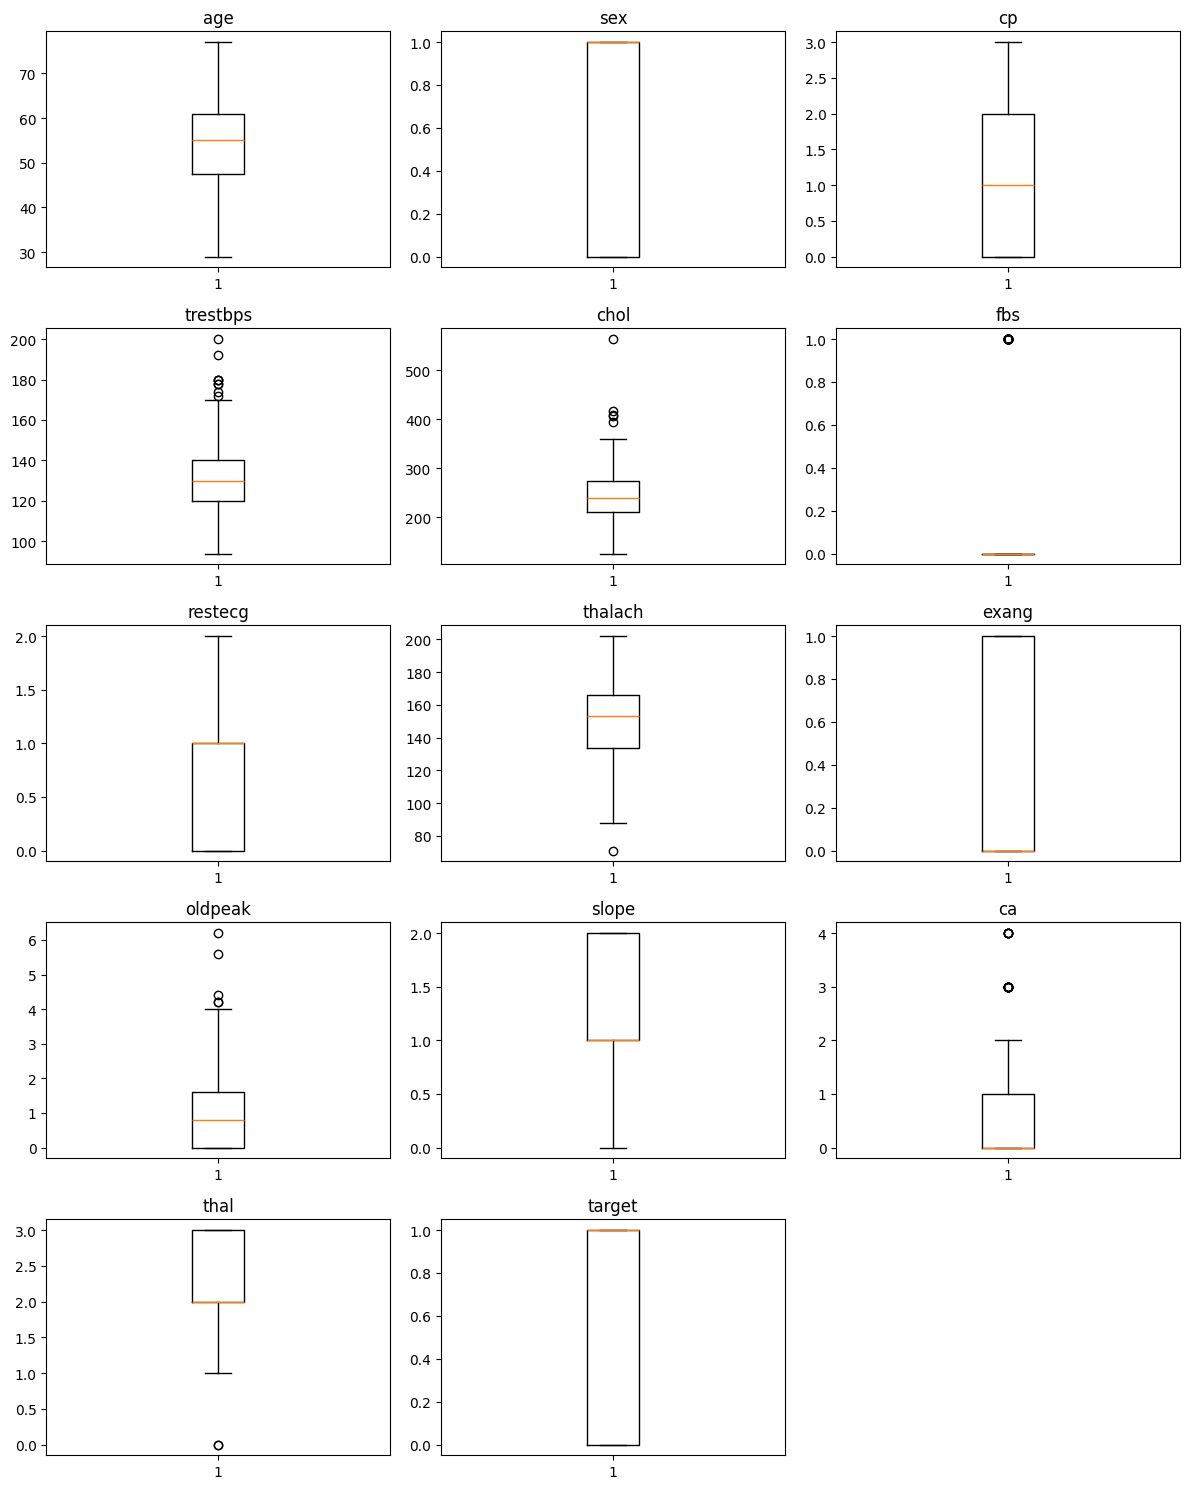

-------------------------------------------
  FEATURE SCALING - DataFrame by standard  
-------------------------------------------
Before scaling - DataFrame
age: mean=54.37, std=9.08
sex: mean=0.68, std=0.47
cp: mean=0.97, std=1.03
trestbps: mean=131.62, std=17.54
chol: mean=246.26, std=51.83
fbs: mean=0.15, std=0.36
restecg: mean=0.53, std=0.53
thalach: mean=149.65, std=22.91
exang: mean=0.33, std=0.47
oldpeak: mean=1.04, std=1.16
slope: mean=1.40, std=0.62
ca: mean=0.73, std=1.02
thal: mean=2.31, std=0.61
target: mean=0.54, std=0.50



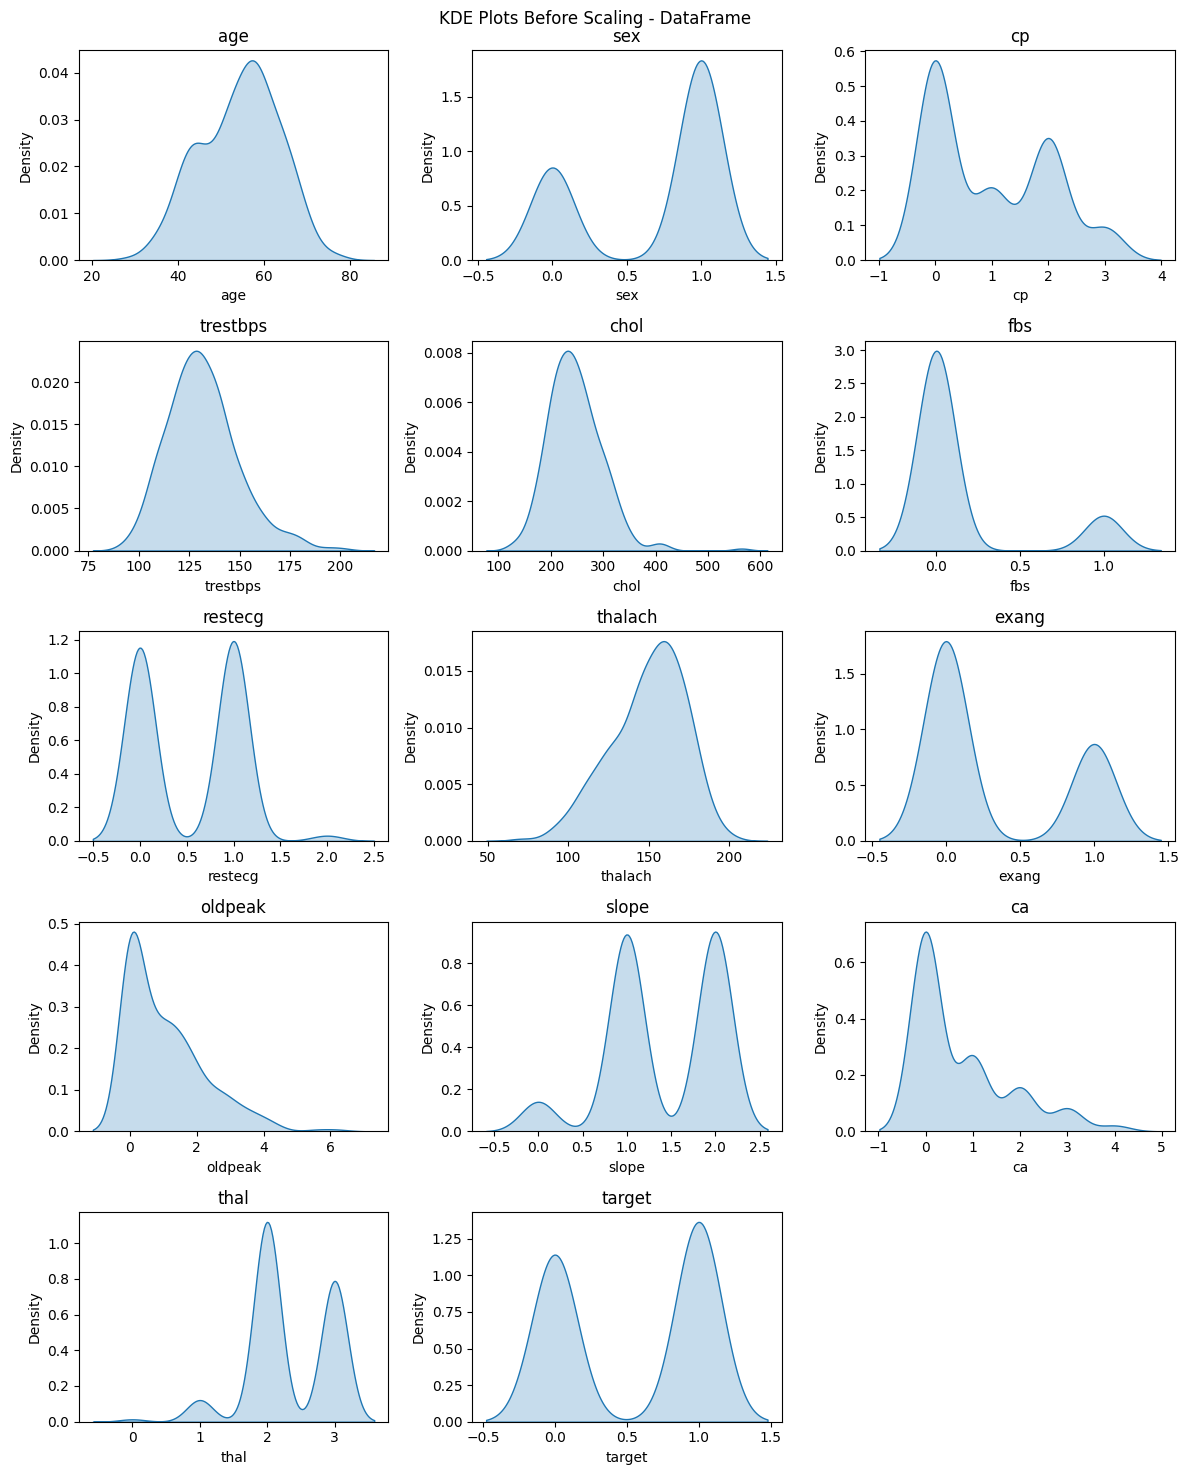

After scaling - DataFrame
age: mean=0.00, std=1.00
sex: mean=-0.00, std=1.00
cp: mean=0.00, std=1.00
trestbps: mean=-0.00, std=1.00
chol: mean=-0.00, std=1.00
fbs: mean=-0.00, std=1.00
restecg: mean=0.00, std=1.00
thalach: mean=-0.00, std=1.00
exang: mean=-0.00, std=1.00
oldpeak: mean=0.00, std=1.00
slope: mean=-0.00, std=1.00
ca: mean=-0.00, std=1.00
thal: mean=-0.00, std=1.00
target: mean=0.54, std=0.50



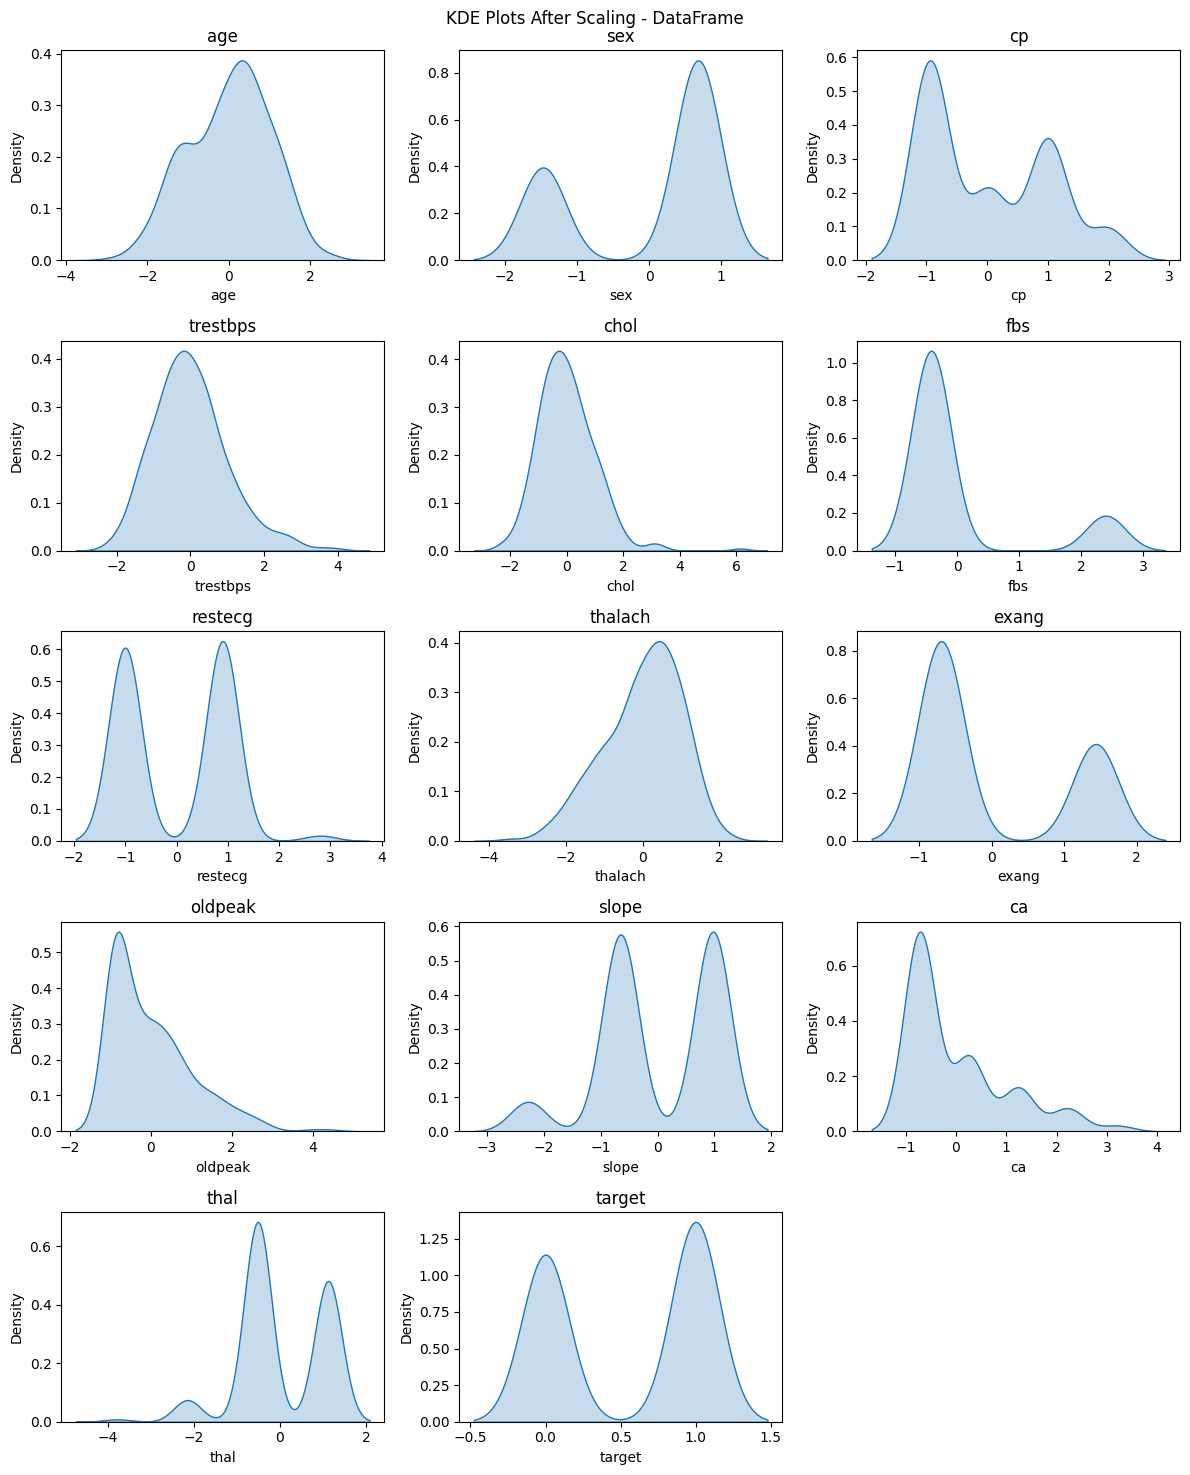

-------------------------------------------
        HANDLE SKEWNESS - DataFrame        
-------------------------------------------
Skewness before - DataFrame:
age        -0.202463
sex        -0.791335
cp          0.484732
trestbps    0.713768
chol        1.143401
fbs         1.986652
restecg     0.162522
thalach    -0.537410
exang       0.742532
oldpeak     1.269720
slope      -0.508316
ca          1.310422
thal       -0.476722
target     -0.179821
dtype: float64



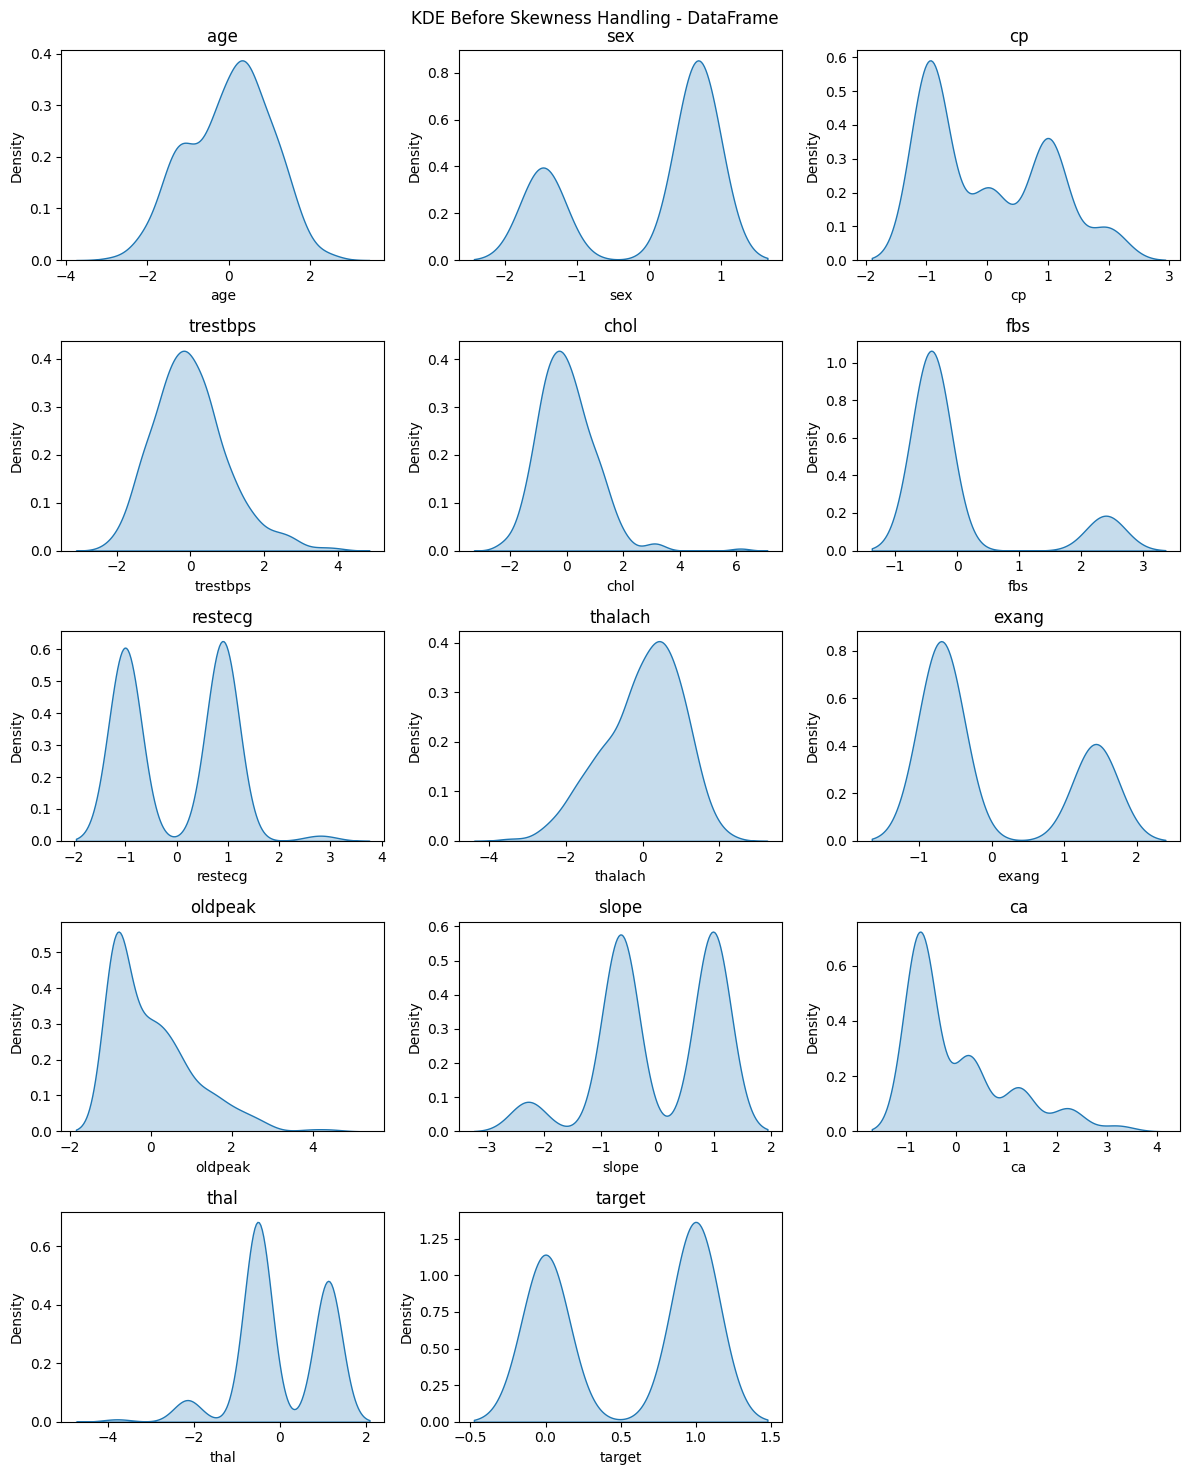

Skewness after - DataFrame:
age         0.012016
sex        -0.791335
cp          0.213591
trestbps    0.009819
chol        0.010054
fbs         1.986652
restecg     0.104045
thalach    -0.007206
exang       0.742532
oldpeak     0.252136
slope      -0.193207
ca          0.492816
thal       -0.199793
target     -0.179821
dtype: float64



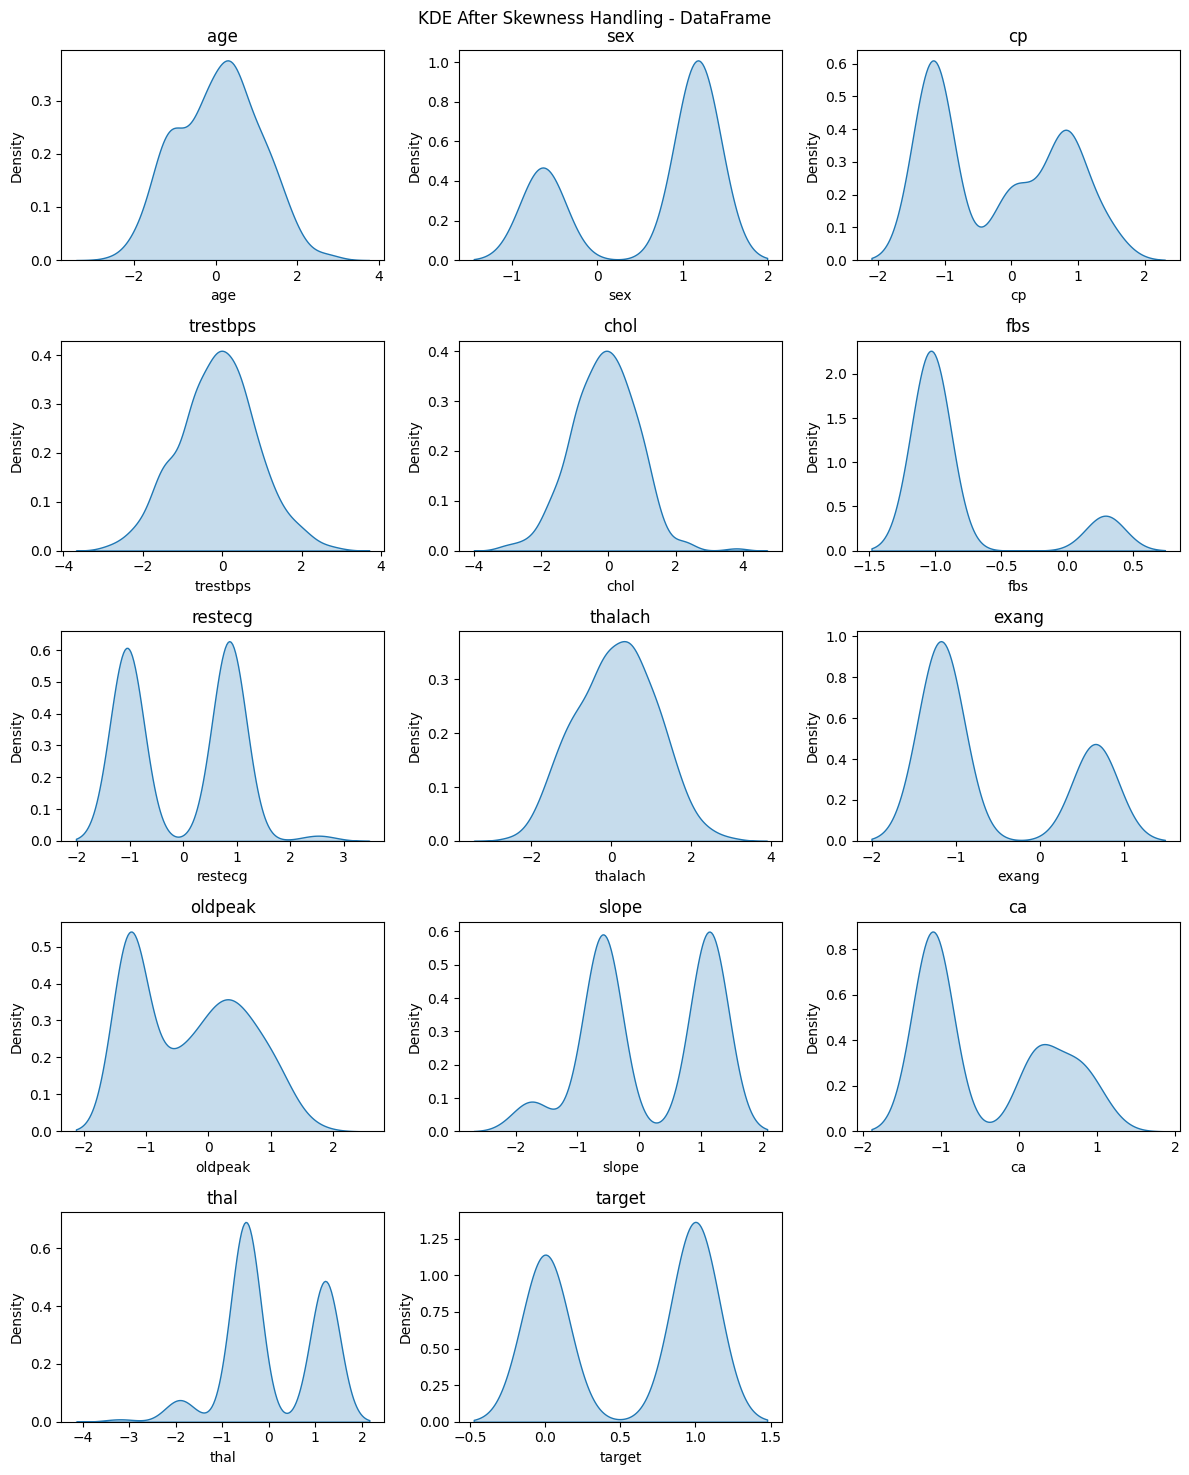

-------------------------------------------
                 SPLIT DATA                
-------------------------------------------
Data split into train and test sets with test size 0.2.
y Lables balance target
1    54.545455
0    45.454545
Name: count, dtype: float64%.
make apply = True if NEEDS IMBALANCE CHANGE?:
-------------------------------------------
              IMBALANCE HANDLE             
-------------------------------------------
Before Applying SMOTETOMEK
target
1    132
0    110
Name: count, dtype: int64
After Applying SMOTETOMEK
target
0    132
1    132
Name: count, dtype: int64


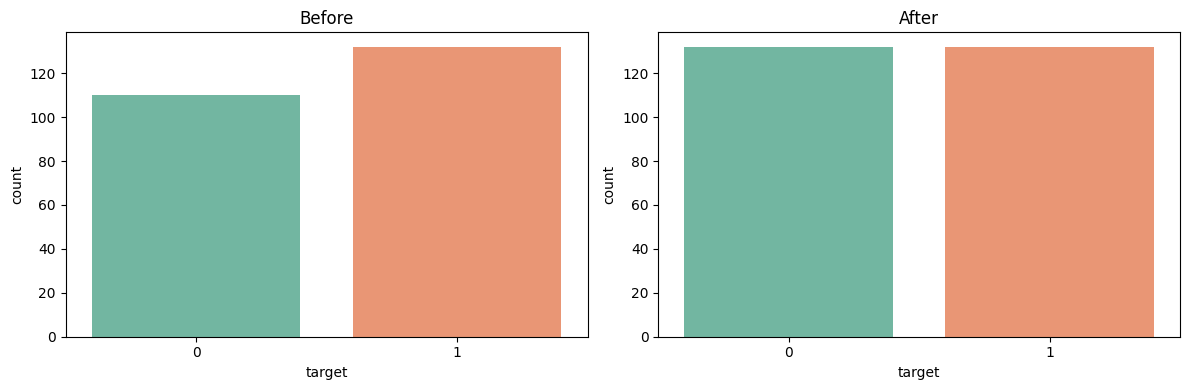

make apply = True if NEEDS PCA?:
-------------------------------------------
                PCA CANCELED               
-------------------------------------------
-------------------------------------------
        VISUALIZING DATA - DataFrame       
-------------------------------------------


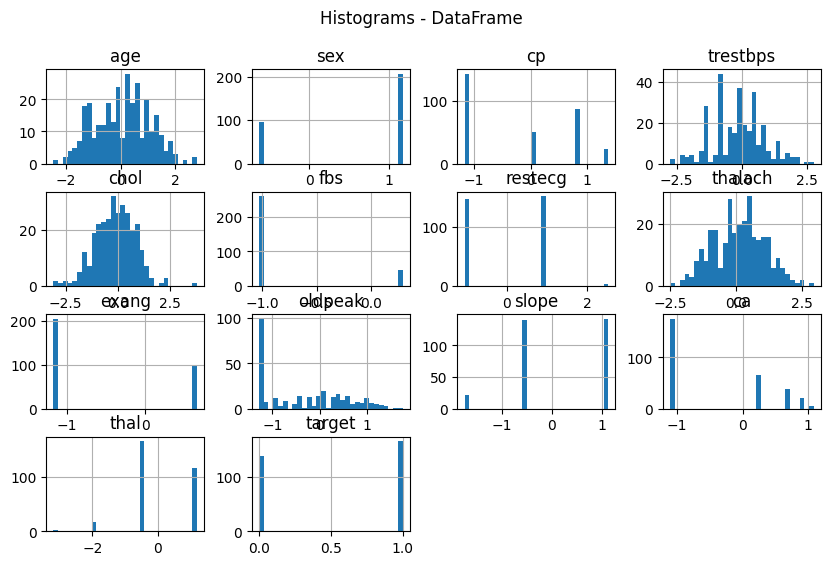

-------------------------------------------
              MODEL SELECTION              
-------------------------------------------

Logistic Regression | accuracy:
  CV fold scores: [0.81481481 0.81481481 0.81481481 0.88888889 0.84615385 0.80769231
 0.88461538 0.92307692 0.96153846 0.84615385]
  Mean: 0.8603, Std: 0.0500

Sorted Model Performance:
Logistic Regression: 0.8603

Best Model: Logistic Regression
-------------------------------------------
              MODEL EVALUATION             
-------------------------------------------
-------------------------------------------
Evaluating model: Logistic Regression
-------------------------------------------

Evaluating model: Logistic Regression
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.71      0.78        28
           1       0.79      0.91      0.85        33

    accuracy                           0.82        61
   macro avg       0.83      0.81      0.81       

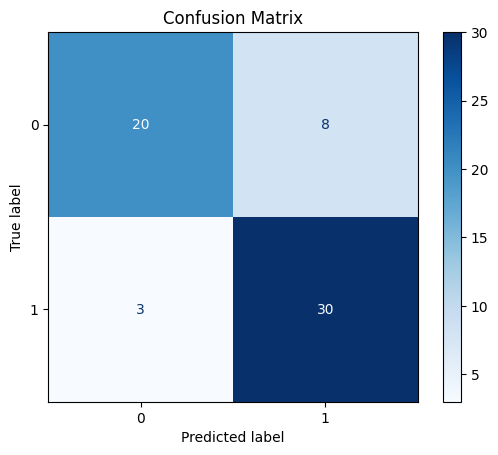

In [45]:
from sklearn.linear_model import LinearRegression , LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor , RandomForestClassifier

df = pd.read_csv("Heart Disease Dataset.csv")
project = MachineLearning(df=df , target='target' , classification=True)
project.display_data()
project.handle_missing_values(impute_strategy="median")
project.outliers_detection(box_plot=True)
project.scaling_features(scaling_method="standard")
project.handle_skewness(threshold=0)
project.split_data(classification=True , test_size=0.2 , random_state=85)
project.imbalance_handling(apply=True ,method="smote")
project.pca(apply=False)
project.visualize_data(histogram=True)

logR = LogisticRegression(
    solver='saga',
    penalty='elasticnet',
    l1_ratio=0.8,
    C=0.23,
    max_iter=1000
)

models_dict = {
    "Logistic Regression": logR
}

project.model_selection(models_dict=models_dict, print_results=True , ascending=True ,scoring="accuracy" , cv=10)
project.model_Training_evaluation(models_dict=models_dict , classification=True , classification_report=True)
project.model_visualization(models_dict=models_dict , classification=True)


-------------------------------------------
                 DataFrame                 
-------------------------------------------
Target: Species

-------------------------------------------
                    HEAD                   
-------------------------------------------
   SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0            5.1           3.5            1.4           0.2  Iris-setosa
1            4.9           3.0            1.4           0.2  Iris-setosa
2            4.7           3.2            1.3           0.2  Iris-setosa
3            4.6           3.1            1.5           0.2  Iris-setosa
4            5.0           3.6            1.4           0.2  Iris-setosa 

-------------------------------------------
                    INFO                   
-------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  

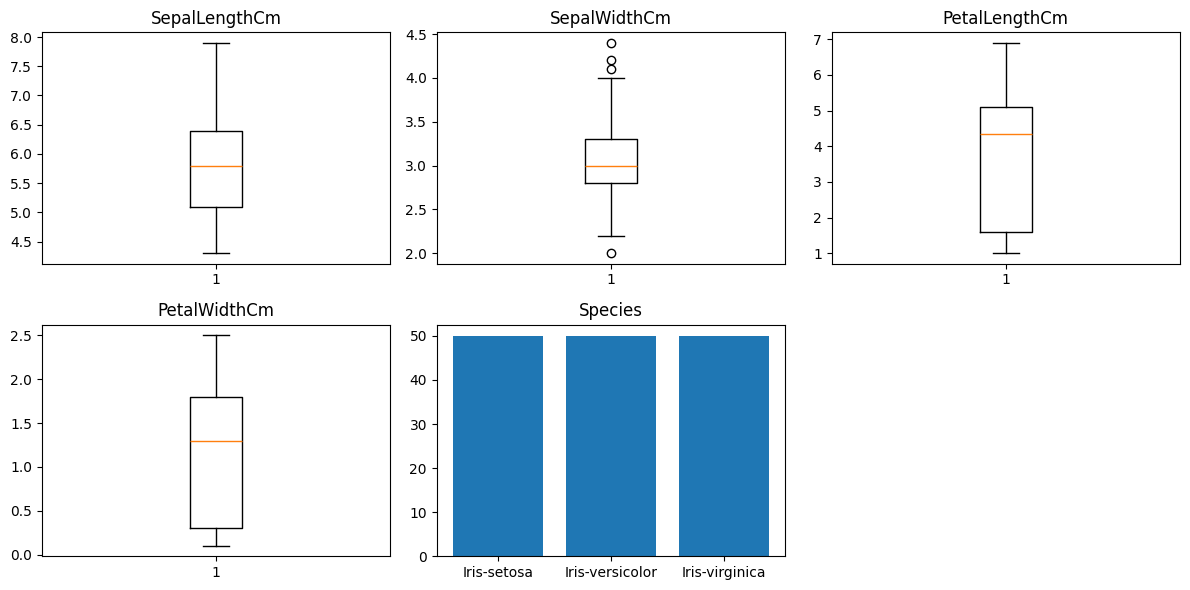

-------------------------------------------
  FEATURE SCALING - DataFrame by standard  
-------------------------------------------
Before scaling - DataFrame
SepalLengthCm: mean=5.84, std=0.83
SepalWidthCm: mean=3.05, std=0.43
PetalLengthCm: mean=3.76, std=1.76
PetalWidthCm: mean=1.20, std=0.76



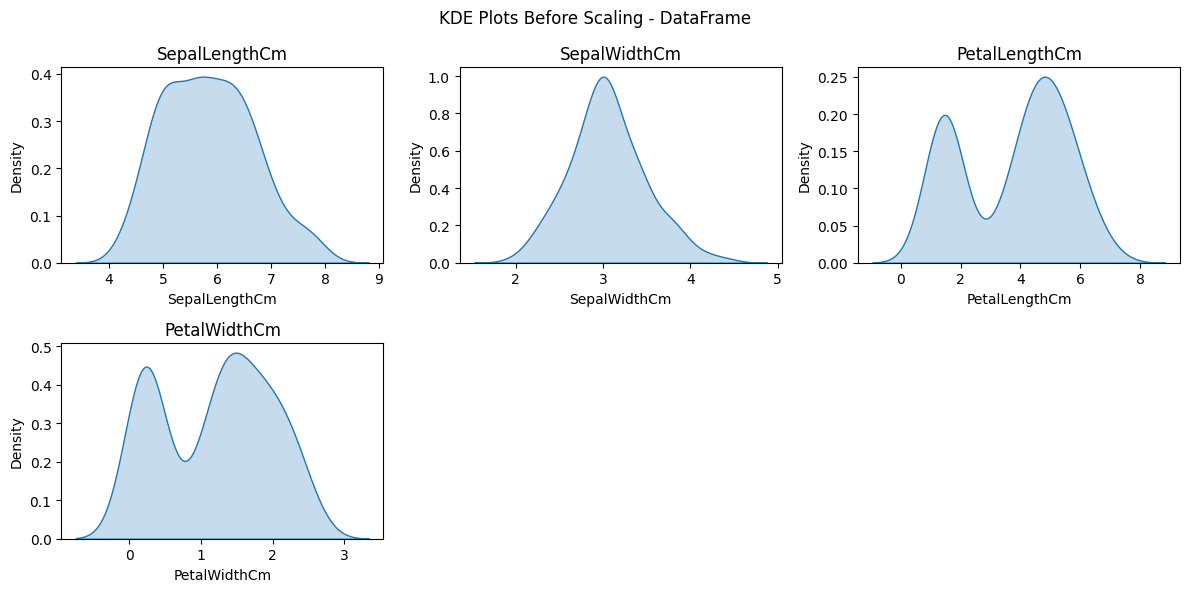

After scaling - DataFrame
SepalLengthCm: mean=-0.00, std=1.00
SepalWidthCm: mean=-0.00, std=1.00
PetalLengthCm: mean=0.00, std=1.00
PetalWidthCm: mean=-0.00, std=1.00



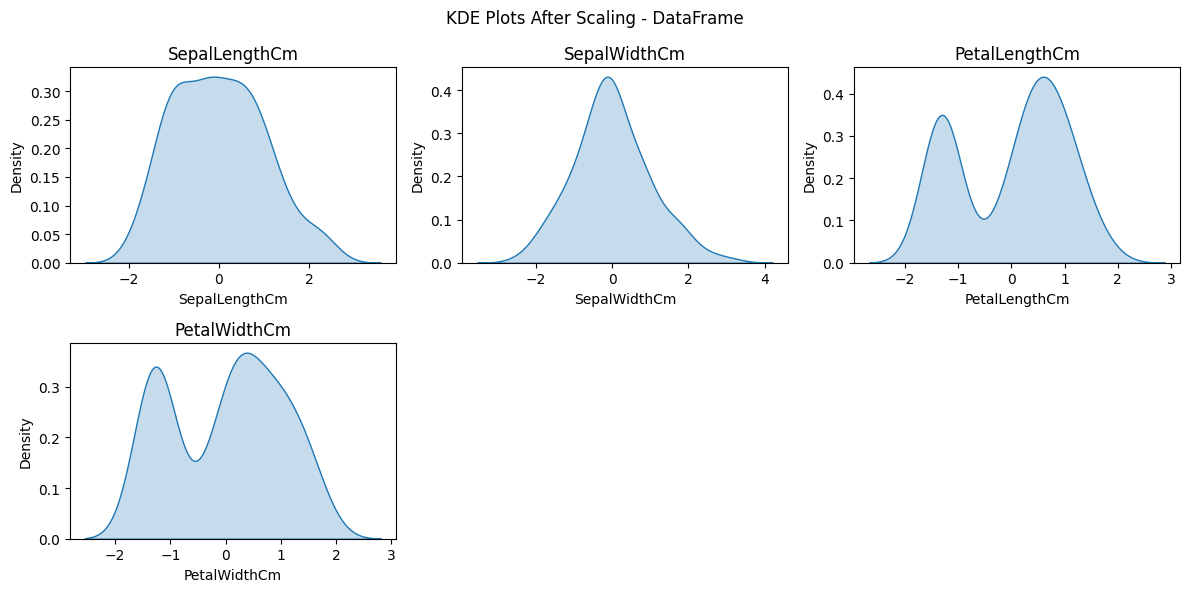

-------------------------------------------
        HANDLE SKEWNESS - DataFrame        
-------------------------------------------
Skewness before - DataFrame:
SepalLengthCm    0.314911
SepalWidthCm     0.334053
PetalLengthCm   -0.274464
PetalWidthCm    -0.104997
dtype: float64



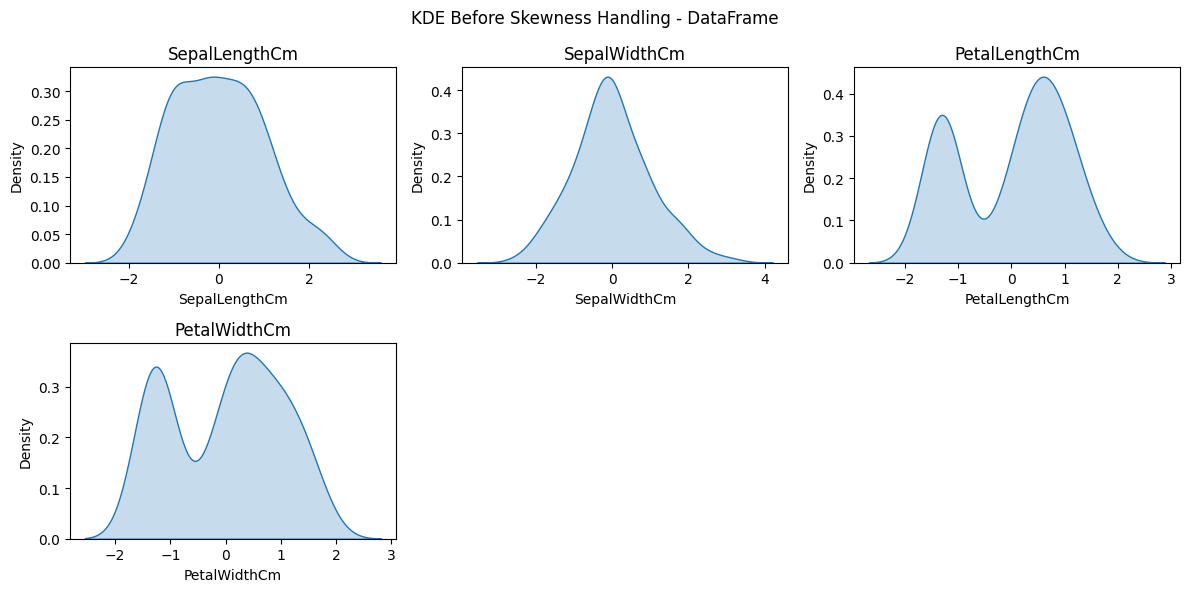

Skewness after - DataFrame:
SepalLengthCm    0.314911
SepalWidthCm     0.334053
PetalLengthCm   -0.274464
PetalWidthCm    -0.104997
dtype: float64



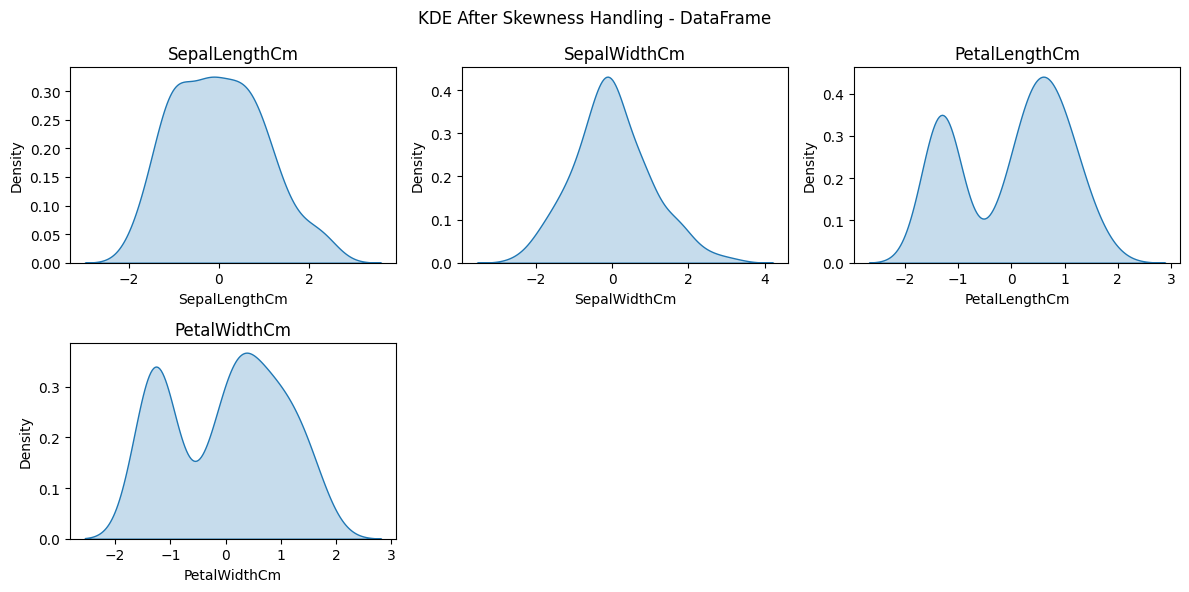

-------------------------------------------
  ENCODE CATEGORICAL VARIABLES - DataFrame 
-------------------------------------------
before encoding categorical variables in DataFrame, shape: (150, 5)


After encoding categorical variables in DataFrame, shape: (150, 5)
-------------------------------------------
                 SPLIT DATA                
-------------------------------------------
Data split into train and test sets with test size 0.2.
make apply = True if NEEDS PCA?:
-------------------------------------------
                PCA CANCELED               
-------------------------------------------
-------------------------------------------
        VISUALIZING DATA - DataFrame       
-------------------------------------------
-------------------------------------------
              MODEL SELECTION              
-------------------------------------------

Logistic Regression | accuracy:
  CV fold scores: [0.91666667 1.         1.         1.         1.         0.83333

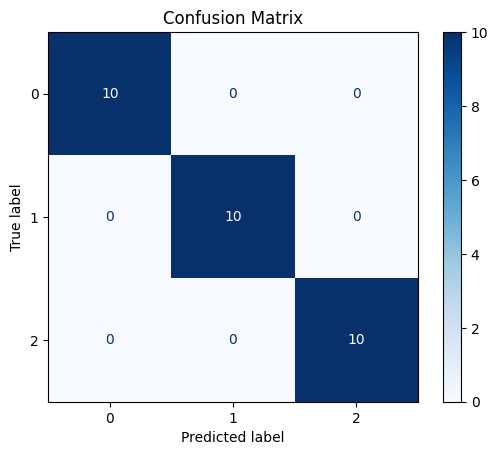

In [46]:
from sklearn.linear_model import LinearRegression , LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor , RandomForestClassifier

df_2 = pd.read_csv("Iris.csv").drop(columns=["Id"])
project_2 = MachineLearning(df=df_2 , target='Species' , classification=True)
project_2.display_data()
project_2.handle_missing_values(impute_strategy="median")
project_2.outliers_detection(box_plot=True)
project_2.scaling_features(scaling_method="standard")
project_2.handle_skewness(threshold=0.5)
project_2.encode_categorical_variables(label_encoding_cols=["Species"])
project_2.split_data(classification=True , test_size=0.2 , random_state=85)
project_2.pca(apply=False)
project_2.visualize_data(histogram=False)

logR_2 = LogisticRegression(
    multi_class='multinomial',
    solver='saga',
    penalty='elasticnet',
    l1_ratio=0.8,
    C=0.23,
    max_iter=1000
)

models_dict = {
    "Logistic Regression": logR_2
}

project_2.model_selection(models_dict=models_dict, print_results=True , ascending=True ,scoring="accuracy" , cv=10)
project_2.model_Training_evaluation(models_dict=models_dict , classification=True , classification_report=True)
project_2.model_visualization(models_dict=models_dict , classification=True)


-------------------------------------------
                 DataFrame                 
-------------------------------------------
Target: Salary

-------------------------------------------
                    HEAD                   
-------------------------------------------
   YearsExperience  Salary
0              1.1   39343
1              1.3   46205
2              1.5   37731
3              2.0   43525
4              2.2   39891 

-------------------------------------------
                    INFO                   
-------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   YearsExperience  35 non-null     float64
 1   Salary           35 non-null     int64  
dtypes: float64(1), int64(1)
memory usage: 692.0 bytes

-------------------------------------------
       SUMMARY (Mean / Median / Std)  

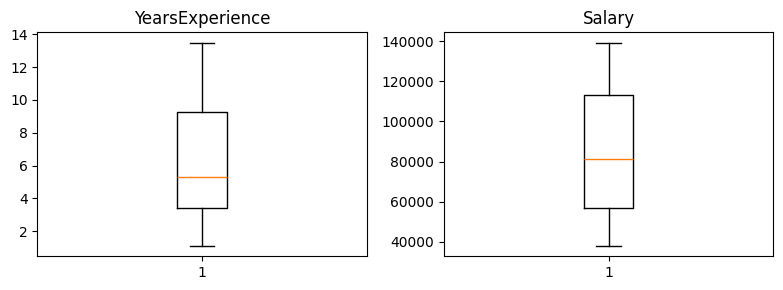

-------------------------------------------
   FEATURE SCALING - DataFrame by min_max  
-------------------------------------------
Before scaling - DataFrame
YearsExperience: mean=6.31, std=3.62
Salary: mean=83945.60, std=32162.67



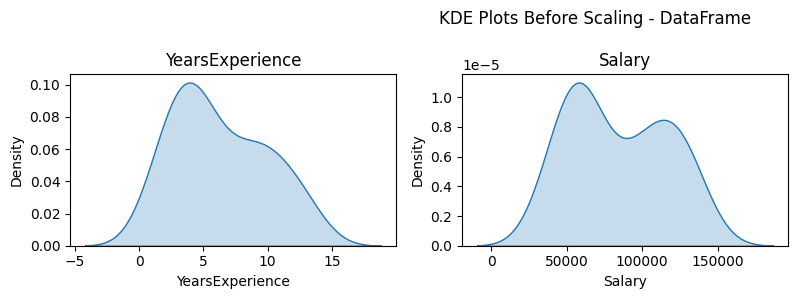

After scaling - DataFrame
YearsExperience: mean=0.42, std=0.29
Salary: mean=83945.60, std=32162.67



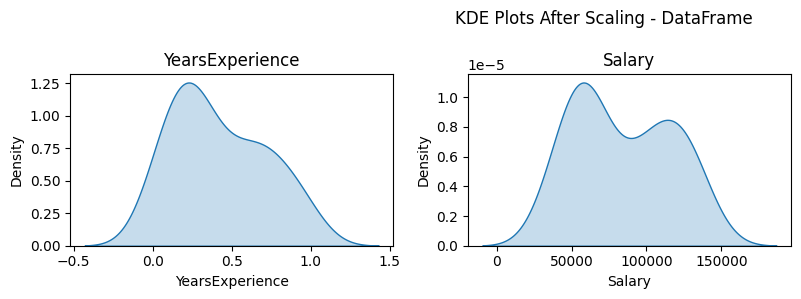

-------------------------------------------
                 SPLIT DATA                
-------------------------------------------
Data split into train and test sets with test size 0.2.
make apply = True if NEEDS PCA?:
-------------------------------------------
                PCA CANCELED               
-------------------------------------------
-------------------------------------------
        VISUALIZING DATA - DataFrame       
-------------------------------------------
-------------------------------------------
              MODEL SELECTION              
-------------------------------------------

Linear Regression | r2:
  CV fold scores: [ 0.98857037  0.86909373  0.3833452   0.94561655  0.92905624  0.95363386
 -1.20174295  0.340479    0.6877057   0.96457451]
  Mean: 0.5860, Std: 0.6384

Sorted Model Performance:
Linear Regression: 0.5860

Best Model: Linear Regression
-------------------------------------------
              MODEL EVALUATION             
-----------------

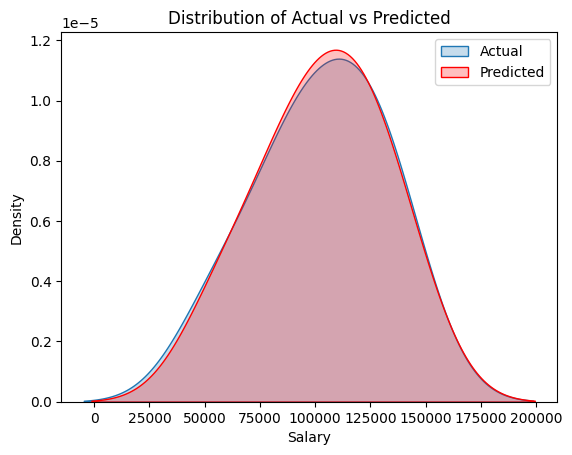

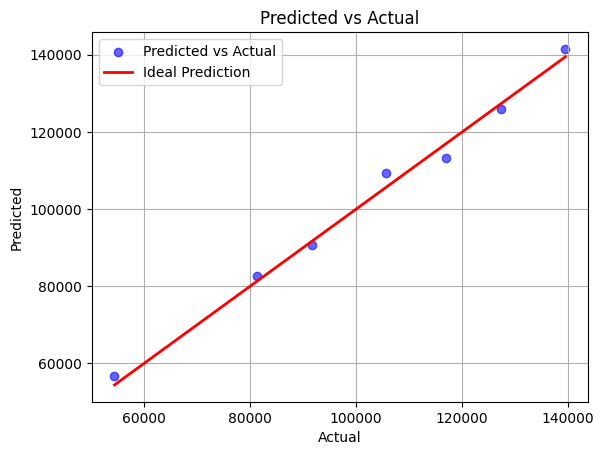

In [47]:
from sklearn.linear_model import LinearRegression

df_3 = pd.read_csv("Salary.csv")
project_3 = MachineLearning(df=df_3 , target='Salary' , classification=False)
project_3.display_data()
project_3.handle_missing_values(impute_strategy="median")
project_3.outliers_detection(box_plot=True)
project_3.scaling_features(scaling_method="min_max")
project_3.split_data(classification=False , test_size=0.2 , random_state=101)
project_3.pca(apply=False)
project_3.visualize_data(histogram=False)

linR_3 = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('model', LinearRegression())
])

models_dict = {
    "Linear Regression": linR_3
}

project_3.model_selection(models_dict=models_dict, print_results=True , ascending=True ,scoring="r2" , cv=10)
project_3.model_Training_evaluation(models_dict=models_dict , classification=False , classification_report=False)
project_3.model_visualization(models_dict=models_dict , classification=False)
